## Import packages

In [1]:
import sys

sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

## Load image

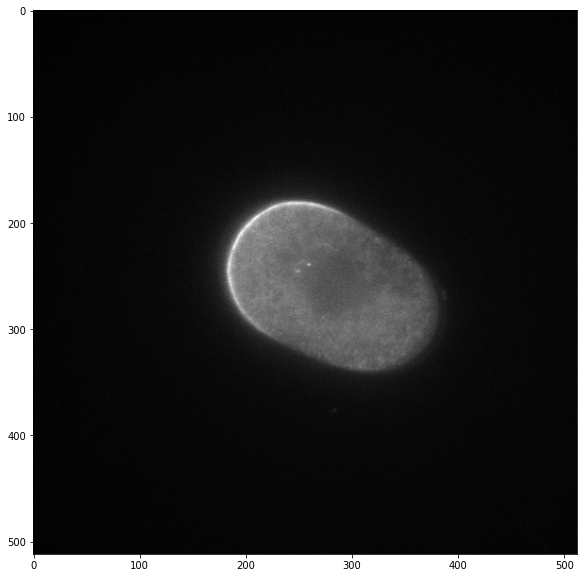

In [153]:
from membranequant.funcs import load_image

file_path = '../test_datasets/dataset2_par2/01/_01_w2488 SP 535-50 Nelio.TIF'
img = load_image(file_path)

%matplotlib inline
plt.imshow(img, cmap='gray')
plt.gcf().set_size_inches(10,10)

## Specify ROI

In [155]:
from membranequant.roi import def_roi

periodic = True

%matplotlib tk
roi = def_roi(img, spline=True, periodic=periodic)
print(roi.shape)

(550, 2)


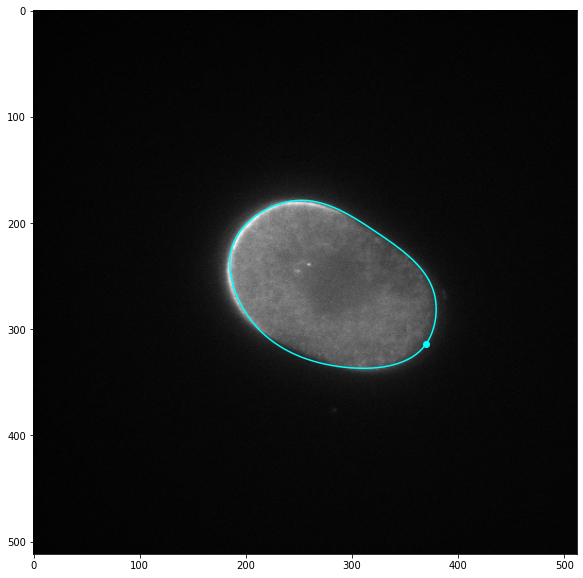

In [156]:
%matplotlib inline
plt.imshow(img, cmap='gray')
plt.plot(roi[:, 0], roi[:, 1], c='aqua')
plt.scatter(roi[0, 0], roi[0, 1], c='aqua')
plt.gcf().set_size_inches(10,10)

## Straighten

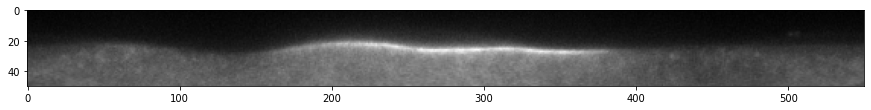

In [157]:
from membranequant.funcs import straighten

thickness = 50
straight = straighten(img, roi=roi, thickness=thickness, interp='cubic')

%matplotlib inline
plt.imshow(straight, cmap='gray')
plt.gcf().set_size_inches(15,15)

## Average profile

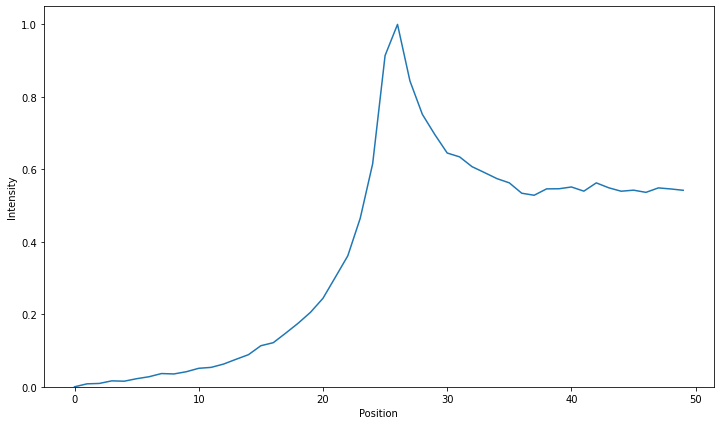

In [160]:
position = 300

profile = straight_smooth[:, position]
profile -= profile[0]
norm = np.max(profile)
profile_norm = profile / norm

%matplotlib inline
plt.plot(profile_norm)
plt.ylim(bottom=0)
plt.xlabel('Position')
plt.ylabel('Intensity')
plt.gcf().set_size_inches(12,7)

## Set up optimisation problem

Create differentiable functions using tensorflow

In [166]:
import tensorflow as tf

sigma = 2

def sim_profile(cyt, mem, offset, thickness=thickness, sigma=sigma):
    positions = np.arange(thickness, dtype=np.float64) + offset
    mem_curve = tf.math.exp(-((positions - thickness / 2) ** 2) / (2 * sigma ** 2))
    cyt_curve = (1 + tf.math.erf((positions - thickness / 2) / sigma)) / 2
    return (mem_curve * mem) + (cyt_curve * cyt)


def loss_function(profile, cyt, mem, offset, thickness=thickness, zerocap=zerocap, freedom=freedom, sigma=sigma):
    return tf.math.reduce_mean((sim_profile(cyt, mem, offset, thickness, zerocap, freedom, sigma) - profile) ** 2)

## Initial guess

Calculate a rough initial guess which will serve as the starting conditions for gradient descent optimisation

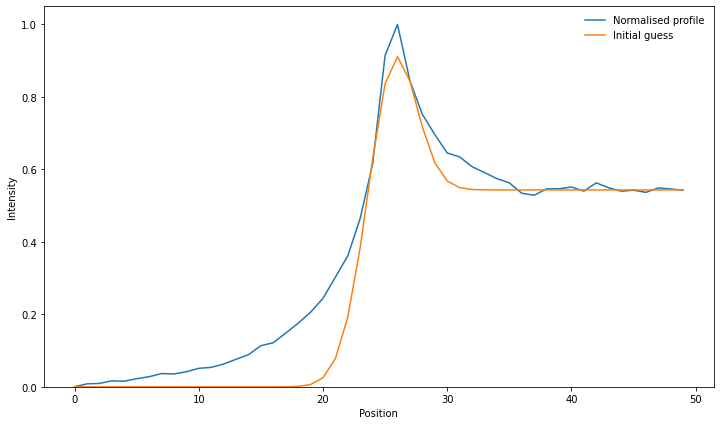

In [167]:
cyt = tf.Variable(np.mean(profile_norm[-5:]), dtype=np.float64)
mem = tf.Variable(np.max(profile_norm) - 0.5 * cyt_0, dtype=np.float64)
offset = tf.Variable(0., dtype=np.float64)

plt.plot(profile_norm, label='Normalised profile')
plt.plot(sim_profile(cyt, mem, offset), label='Initial guess')
plt.ylim(bottom=0)
plt.xlabel('Position')
plt.ylabel('Intensity')
plt.legend(frameon=False)
plt.gcf().set_size_inches(12,7)

## Optimise parameters

Perform gradient descent to optimise the cytoplasmic and membrane concentration parameters, and the offset parameter

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.6011521499318282>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.565670073755066>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.3210115127695197>


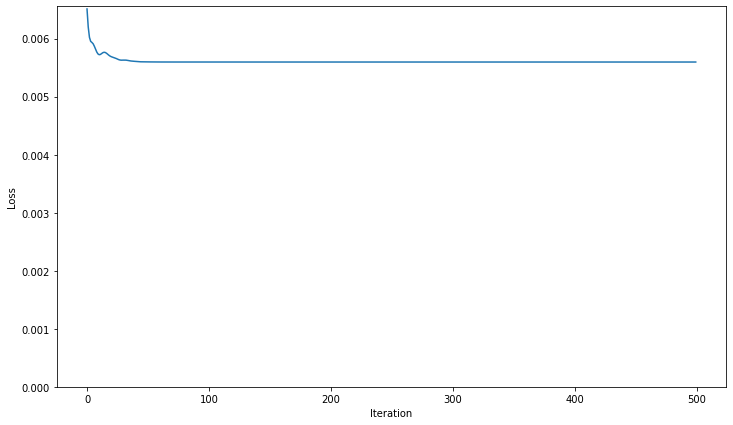

In [163]:
iterations = 500

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
losses = np.zeros(iterations)
for i in range(iterations):
    with tf.GradientTape() as tape:
        loss = loss_function(profile_norm, cyt, mem, offset)
        losses[i] = loss
        var_list = [offset, cyt, mem]
        grads = tape.gradient(loss, var_list)
        opt.apply_gradients(list(zip(grads, var_list)))
    
print(mem)
print(cyt)
print(offset)
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.gcf().set_size_inches(12,7)

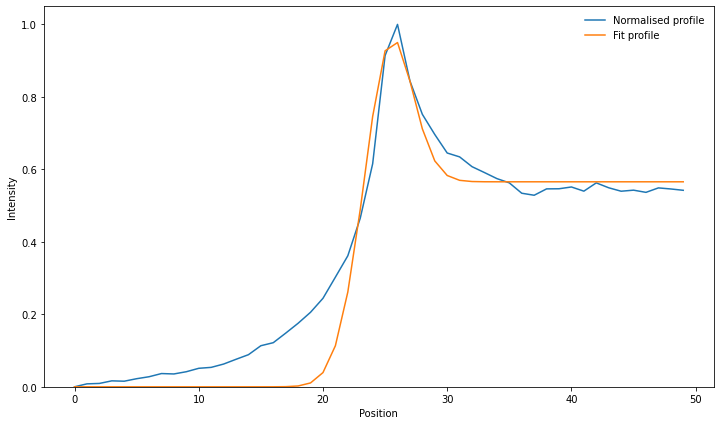

In [164]:
plt.plot(profile_norm, label='Normalised profile')
plt.plot(sim_profile(cyt, mem, offset), label='Fit profile')
plt.xlabel('Position')
plt.ylabel('Intensity')
plt.gcf().set_size_inches(12,7)

## Rescale concentration parameters

Rescale concentration parametrs by normalisation factor

In [165]:
mem_final = mem.numpy() * norm
cyt_final = cyt.numpy() * norm
print(mem_final)
print(cyt_final)

14694.65499948663
13827.32570832107
